<h1>Hawkes Clustering - Exp</h1><br>
Allows for modelling a dataset as a Hawkes process with a exponential kernel. The dataset is first broken down into clusters of events before the model is applied to it.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from HelperFunctions import Clusterise, MultiHist, InterTimes, ComputeClusterLengths, GenerateClusters, ConcatClusters
from TickHelper import TrainInnerClusterExp, SimulateExp, TrainSeriesExp, SavedModel
import os

c:\users\ricard grace\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#convenience variables
sec = 1000000000

#tweakable parameters
data_csv = 'data.csv'
c_id = 1
cluster_size = 30 #30 seconds is good for client 1
cluster_decay_range = (0,20) #the decay range to try (log10 scale) for modelling cluster events
cluster_decay_num = 300 #how many decays to try for cluster training
inner_cluster_decay_range = (-10,10) #the decay range to try (log10 scale) for modelling events within clusters
inner_cluster_decay_num = 10

#files
dist_folder = "saved_dist"
model_folder = "saved_model"

<h2>Data Loading</h2>

Max Time: 244590.07618165 seconds
Num Points: 18845


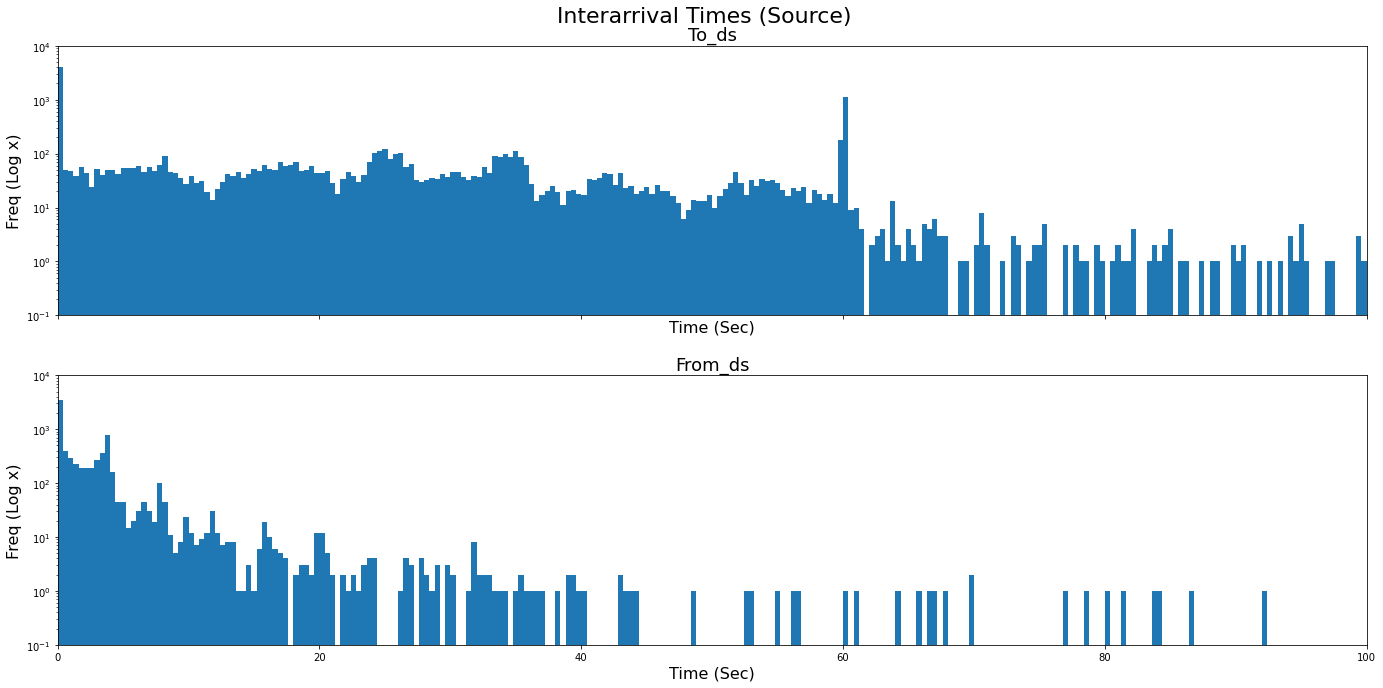

In [3]:
#load raw data
X = pd.read_csv(data_csv)
#X1 = X[(X.client_id == 1) & (X.from_ds == 0) & (X.time < 70000*sec)].time.apply(lambda x:x/sec)
#X2 = X[(X.client_id == 1) & (X.from_ds == 1) & (X.time < 70000*sec)].time.apply(lambda x:x/sec)
X1 = X[(X.client_id == c_id) & (X.from_ds == 0)].time.apply(lambda x:x/sec)
X2 = X[(X.client_id == c_id) & (X.from_ds == 1)].time.apply(lambda x:x/sec)
X1.sort_values
X2.sort_values

maxtime = X1.max()
m = X2.max()
if (m > maxtime):
    maxtime = m
print(f"Max Time: {maxtime} seconds")
print(f"Num Points: {len(X1) + len(X2)}")

#merge to/from into a single 2d array
data = [X1.astype(np.dtype('d')).to_numpy(), X2.astype(np.dtype('d')).to_numpy()]

#calculate interarrivals
interarr = []
for timestamps in data:
    interarr.append(InterTimes(timestamps))
#display interarrivals
MultiHist(interarr, title="Interarrival Times (Source)", subtitles=['To_ds', 'From_ds'], data_range=(0,100), y_max=10000)

<h2>Clustering</h2>

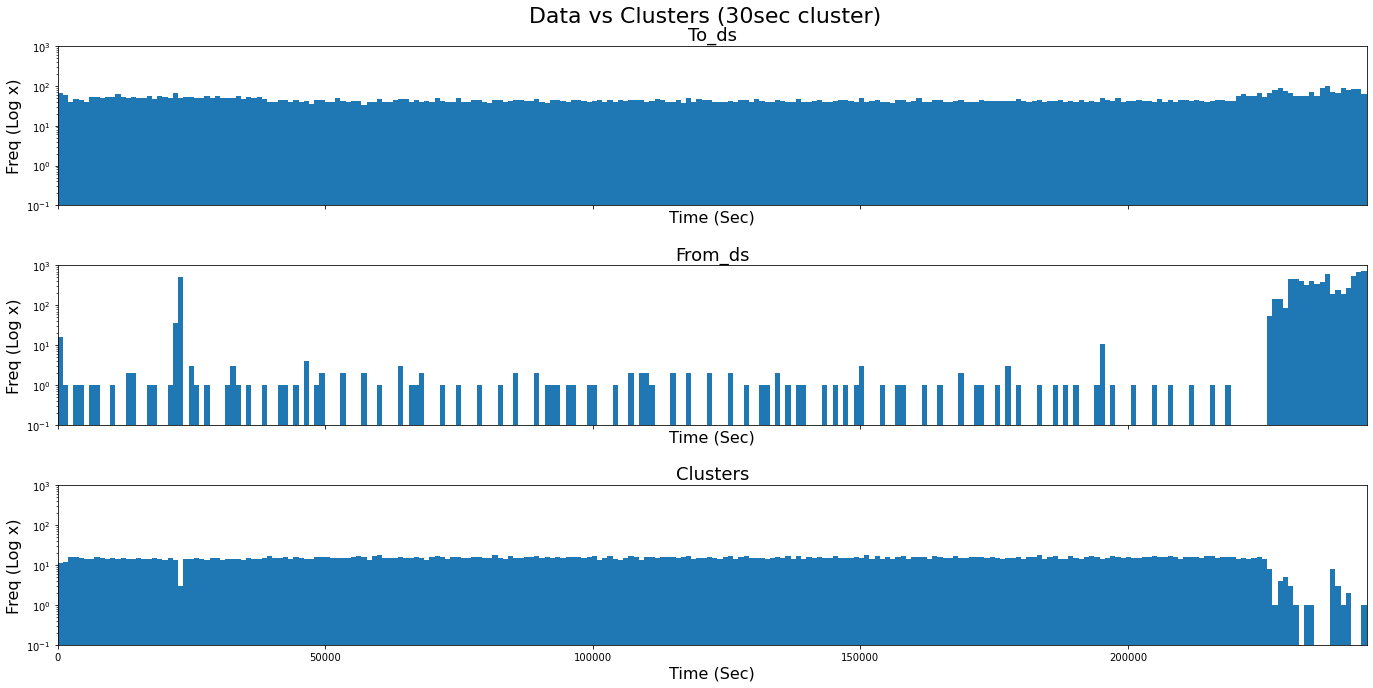

In [4]:
clusters = []
inner_cluster_times = []

#clusters[0], inner_cluster_times[0] = Clusterise(data[0], cluster_size)
#clusters[1], inner_cluster_times[1] = Clusterise(data[1], cluster_size)

clusters, inner_cluster_times = Clusterise(data, cluster_size)

MultiHist([data[0], data[1], clusters], title=f'Data vs Clusters ({cluster_size}sec cluster)', subtitles=['To_ds', 'From_ds', 'Clusters'], y_max=1000)

<h2>Cluster Training and Simulation</h2>

<h3>Training</h3>

Decay Range: 1.0 -> 1e+20


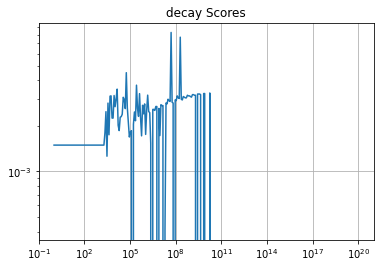


Training Done
Float Errors: 7 (2.333333333333333%)
Baseline Errors: 0 (0.0%)
Successful Results: 293 (97.66666666666666%)


Best Score: 0.008275563266907739
Best Decay: 49238826.31706732


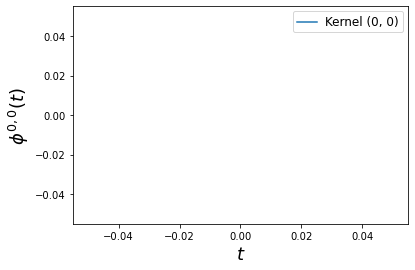

Adjacency: [[0.]]
Baseline: [0.00499178]
Coeffs: [0.00499178 0.        ]


In [5]:
learner, sim_decay = TrainSeriesExp(clusters, num_decays=cluster_decay_num, decay_low=cluster_decay_range[0], decay_high=cluster_decay_range[1])

<h3>Simulation</h3>

Starting sim
Simulated 1269 points


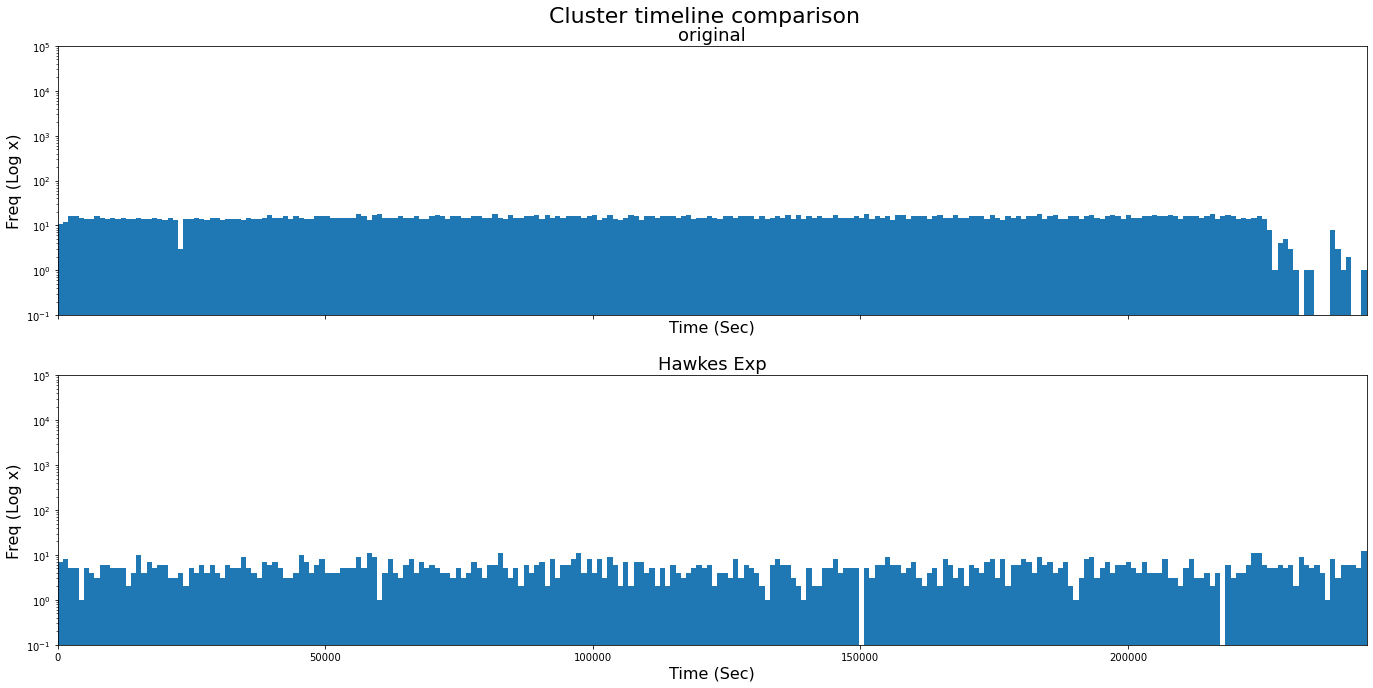

In [6]:
#save the model
smodel = SavedModel(learner, 0, 0, is_em=False, decay=sim_decay)
fname = os.path.join(model_folder, f"HawkesExp_cluster_model_c{c_id}.npz")
smodel.Save(fname)
sim_baseline = smodel.baseline
sim_adjacency = smodel.intensity

#simulate and graph a timeline
sim_clusters = SimulateExp(sim_baseline, sim_adjacency, sim_decay, maxtime)[0]
MultiHist([clusters,sim_clusters], title='Cluster timeline comparison', subtitles=['original', 'Hawkes Exp'], y_max=100000)

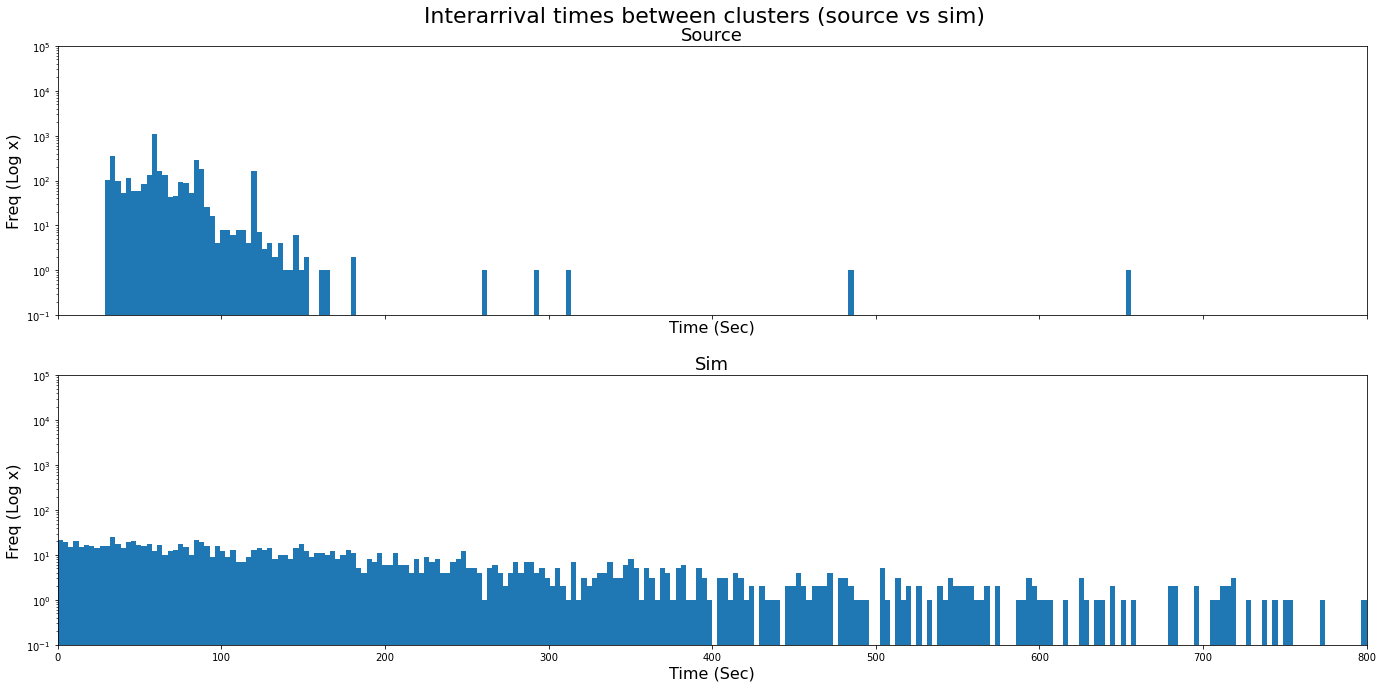

In [7]:
#get cluster interarivals
interarr = InterTimes(clusters)
interarr.sort()
sim_interarr = InterTimes(sim_clusters)
sim_interarr.sort()

MultiHist([interarr, sim_interarr], title="Interarrival times between clusters (source vs sim)", subtitles=['Source','Sim'], data_range=(0,800), y_max=100000)

#save the simulation
fname = os.path.join(dist_folder, f"HawkesExp_cluster_dist_c{c_id}.npz")
np.savez(fname, deltas=sim_interarr)

<h2>Inner-Cluster Training and Simulation</h2>

<h3>Training</h3>

Training on 3556 clusters
Decay Range: 1e-10 -> 10000000000.0


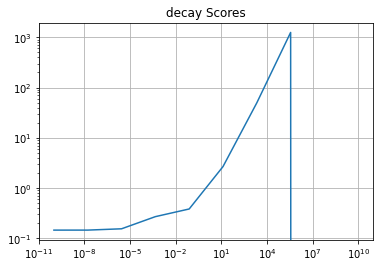


Training Done
Float Errors: 0 (0.0%)
Baseline Errors: 0 (0.0%)
Successful Results: 10 (100.0%)


Best Score: 1250.7977845397008
Best Decay: [[359381.36638046 359381.36638046]
 [359381.36638046 359381.36638046]]


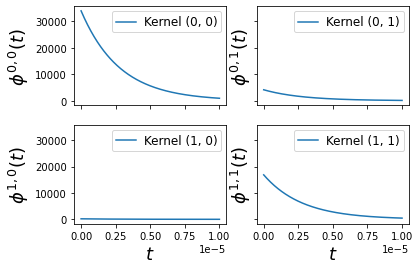

Adjacency: [[0.09468085 0.01152736]
 [0.00054267 0.04685453]]
Baseline: [0.99962367 0.99960222]
Coeffs: [9.99623670e-01 9.99602218e-01 9.46808502e-02 1.15273552e-02
 5.42665616e-04 4.68545308e-02]


In [8]:
learner, sim_decay = TrainInnerClusterExp(inner_cluster_times, num_decays=inner_cluster_decay_num, decay_low=inner_cluster_decay_range[0], decay_high=inner_cluster_decay_range[1])

<h3>Simulation</h3>

Starting sim
Simulated 528713 points


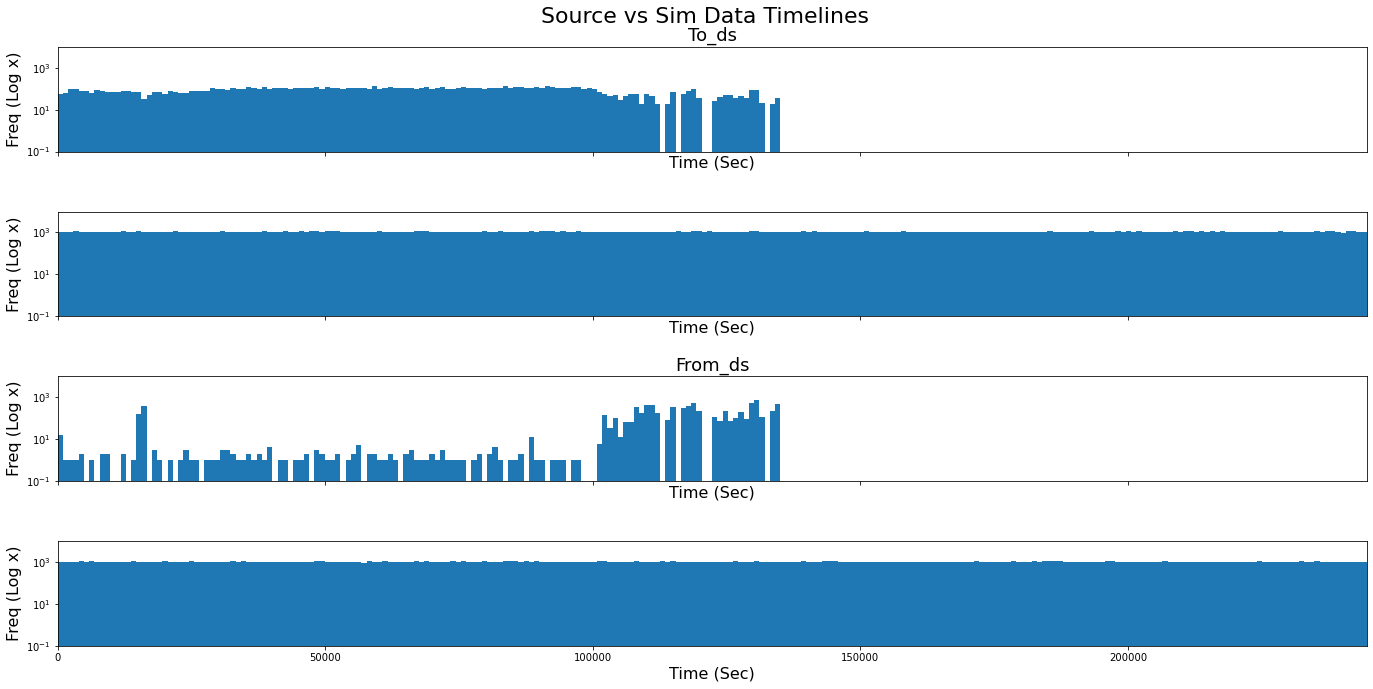

In [9]:
#save the model
smodel = SavedModel(learner, 0, 0, is_em=False, decay=sim_decay)
fname = os.path.join(model_folder, f"HawkesExp_innercluster_model_c{c_id}.npz")
smodel.Save(fname)
sim_baseline = smodel.baseline
sim_adjacency = smodel.intensity

#do the simulation (no clustering)
sim_timestamps = SimulateExp(sim_baseline, sim_adjacency, sim_decay, maxtime)
tstamps = ConcatClusters(inner_cluster_times, 0)

#display timeline comparison
MultiHist([tstamps[0], sim_timestamps[0], tstamps[1], sim_timestamps[1]], title='Source vs Sim Data Timelines', subtitles=['To_ds', '', 'From_ds', ''], y_max=10000)

In [10]:
#do simulation, this time with clustering

#first step, generate statistics on the length of clusters
cluster_lengths = ComputeClusterLengths(inner_cluster_times)
print(f"Median Length: {cluster_lengths[int(len(cluster_lengths)/2)]}")

#generate new clusters using the computed lengths
source_clusters = len(inner_cluster_times)
sim_clusters_goal = source_clusters * 2
nsim_clusters = 0
sim_inner_cluster_times = []

print(f"Source Clusters: {source_clusters}\nGeneration Goal: {sim_clusters_goal}")

#do the actual simulation
while(nsim_clusters < sim_clusters_goal):
    sim_timestamps = SimulateExp(sim_baseline, sim_adjacency, sim_decay, 300000) #generate in blocks of 200000 seconds
    a = GenerateClusters(sim_timestamps, cluster_lengths, cluster_size) #create clusters from the new block
    sim_inner_cluster_times.extend(a)
    l = len(a)
    nsim_clusters += l
    print(f"Added {l} clusters, {nsim_clusters} total ({100/sim_clusters_goal*nsim_clusters}%)")
    
print(f"Simulated {nsim_clusters} clusters of events")
sim_cluster_lengths = ComputeClusterLengths(sim_inner_cluster_times)

Median Length: 25.453611135002575
Source Clusters: 3556
Generation Goal: 7112
Starting sim
Simulated 433185 points
Added 2407 clusters, 2407 total ([2.29824317e+00 5.73647807e+00 6.12487105e+00 ... 3.43691949e+03
 3.43868060e+03 3.43896153e+03]%)
Starting sim
Simulated 432132 points
Added 2423 clusters, 4830 total ([2.29824317e+00 5.73647807e+00 6.12487105e+00 ... 3.43691949e+03
 3.43868060e+03 3.43896153e+03]%)
Starting sim
Simulated 434226 points
Added 2415 clusters, 7245 total ([2.29824317e+00 5.73647807e+00 6.12487105e+00 ... 3.43691949e+03
 3.43868060e+03 3.43896153e+03]%)
Simulated 7245 clusters


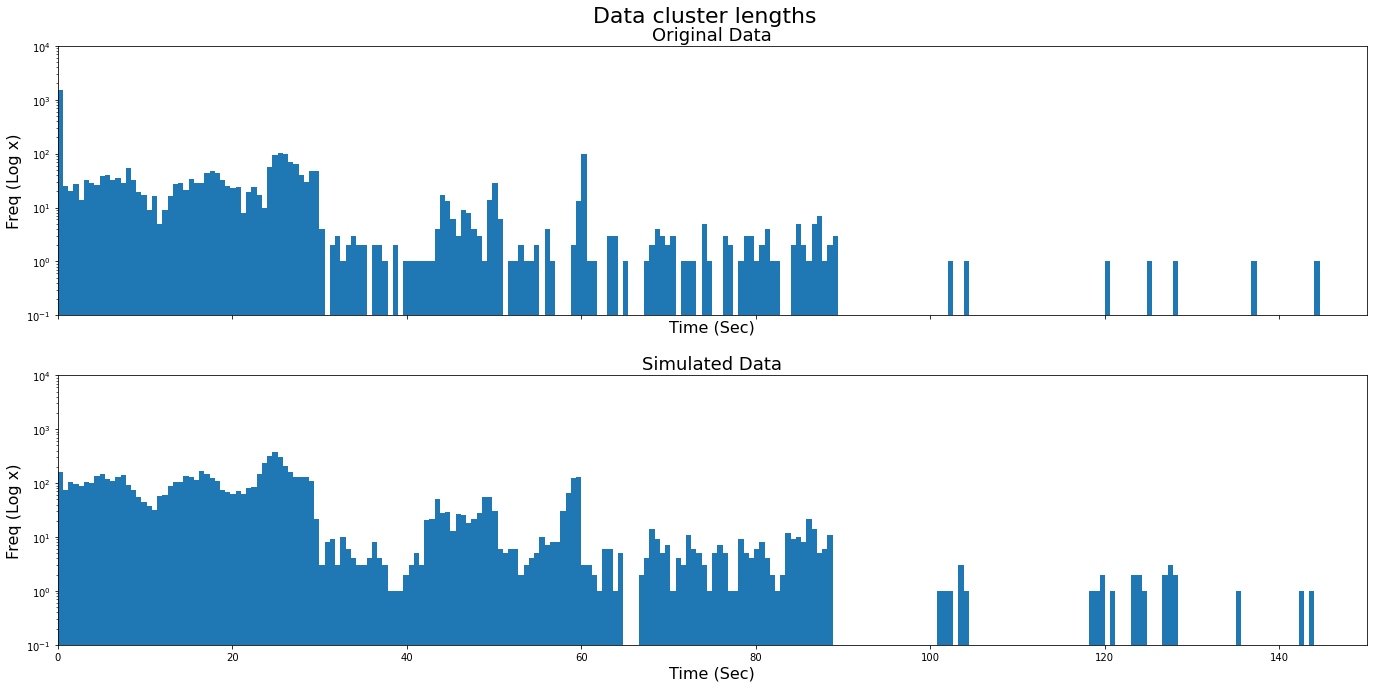

In [18]:
#graph cluster length comparison
MultiHist([cluster_lengths, sim_cluster_lengths], title='Data cluster lengths', subtitles=['Original Data', 'Simulated Data'], data_range=(0,150), y_max=10000)

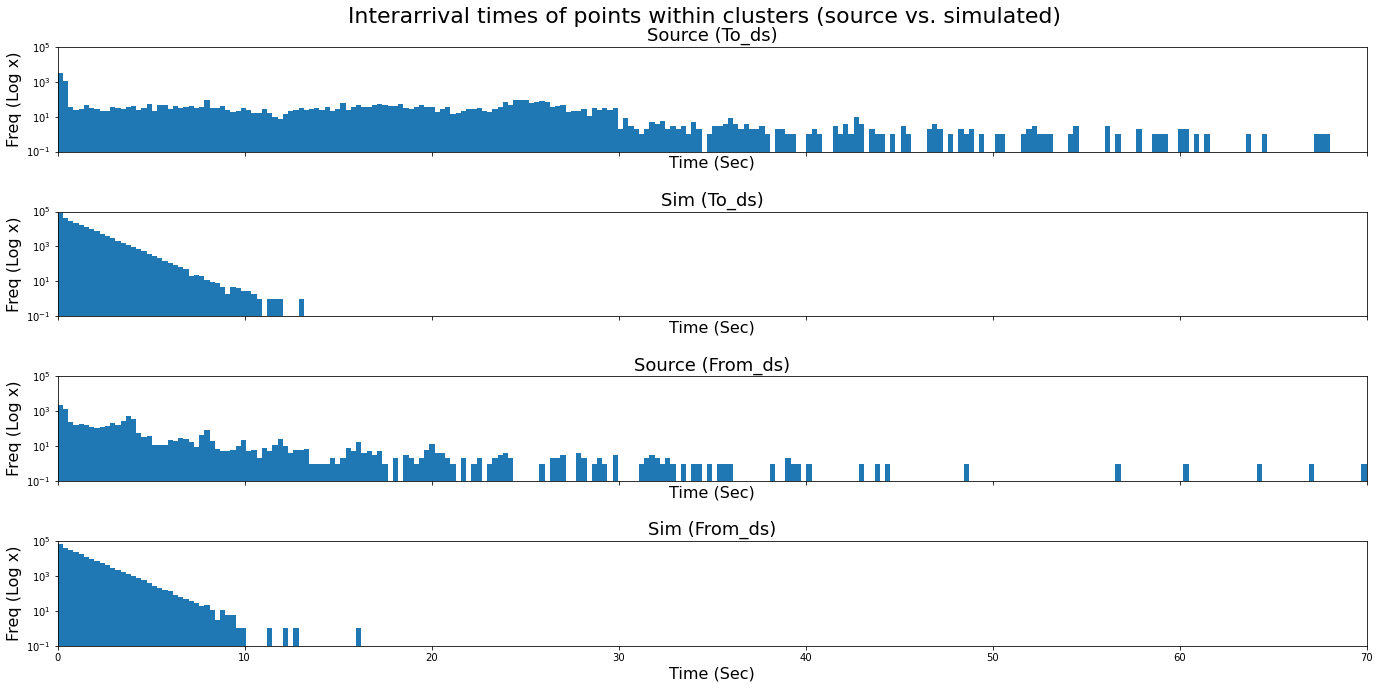

In [20]:
#graph the interarrival distribution of events within clusters.
interarr = [[],[]]
for cluster in inner_cluster_times:
    i = 0
    for series in cluster:
        interarr[i].extend(InterTimes(series))
        i += 1
interarr[0].sort()
interarr[1].sort()

sim_interarr = [[],[]]
for cluster in sim_inner_cluster_times:
    i = 0
    for series in cluster:
        sim_interarr[i].extend(InterTimes(series))
        i += 1
sim_interarr[0].sort()
sim_interarr[1].sort()

#do the graph
MultiHist([interarr[0], sim_interarr[0], interarr[1], sim_interarr[1]], title="Interarrival times of points within clusters (source vs. simulated)", subtitles=['Source (To_ds)','Sim (To_ds)','Source (From_ds)','Sim (From_ds)'], data_range=(0,70), y_max=100000)